Choose a graph type:
1. Fully Random Graph
2. Regular Graph
Enter your choice (1 or 2): 1
Enter number of nodes: 9
Enter maximum edges per node: 4




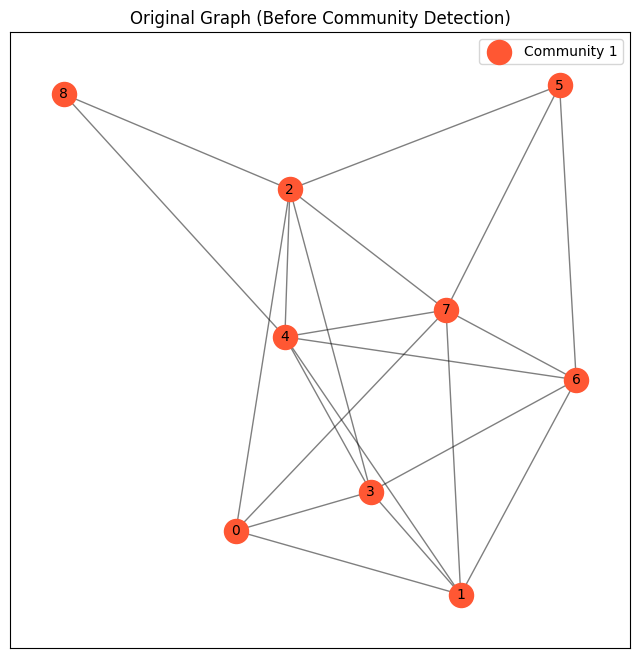

Graph Statistics:
Number of Nodes: 9
Number of Edges: 21
Diameter: 2
Density: 0.5833
Connected: Yes
Bipartite: No
Chromatic Number: 4

Girvan-Newman Communities: [{0, 1, 2, 3, 4, 5, 6, 7}, {8}]


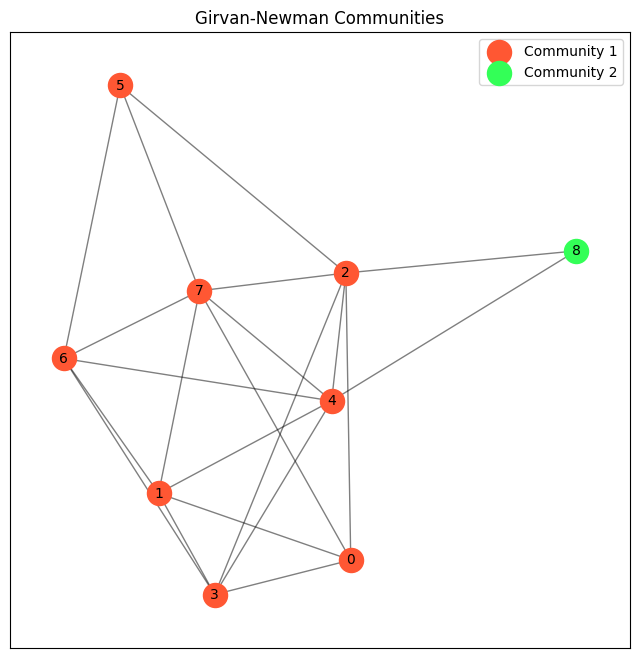


Louvain Communities: [[0, 1, 3], [2, 4, 8], [5, 6, 7]]


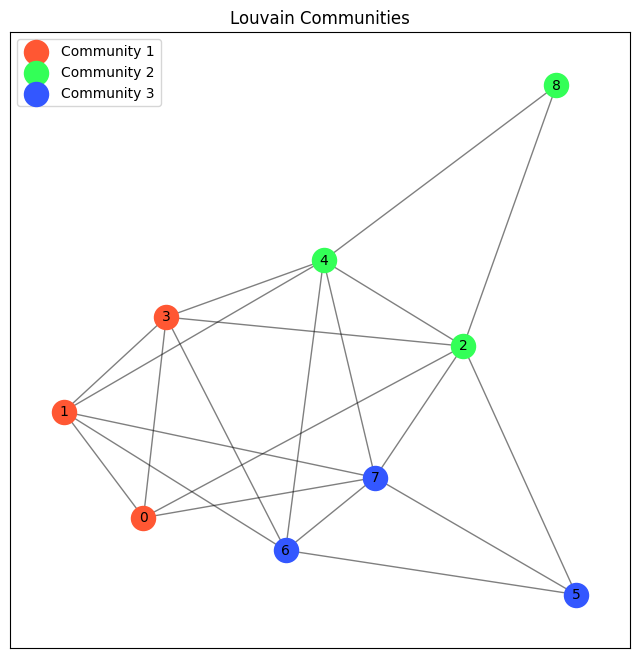

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict, deque

def randomgraph(num_nodes, max_edges_per_node):
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for node in G.nodes():
        num_edges = random.randint(1, max_edges_per_node)
        possible_edges = list(set(G.nodes()) - {node})
        for _ in range(num_edges):
            if possible_edges:
                neighbor = random.choice(possible_edges)
                G.add_edge(node, neighbor)
                possible_edges.remove(neighbor)
    return G

def regulargraph(num_nodes, degree):
    return nx.random_regular_graph(degree, num_nodes)

def edge_betweenness_centrality(G):
    betweenness = defaultdict(float)
    for s in G.nodes():
        S = []
        P = {}
        for v in G.nodes():
            P[v] = []
        sigma = dict.fromkeys(G, 0.0)
        sigma[s] = 1.0
        D = dict.fromkeys(G, -1)
        D[s] = 0
        Q = deque([s])
        while Q:
            v = Q.popleft()
            S.append(v)
            for w in G[v]:
                if D[w] == -1:
                    Q.append(w)
                    D[w] = D[v] + 1
                if D[w] == D[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v)
        delta = dict.fromkeys(G, 0)
        while S:
            w = S.pop()
            for v in P[w]:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])
                if w != s:
                    for v in P[w]:
                        betweenness[(v, w)] += delta[w]
                        betweenness[(w, v)] += delta[w]
    for u, v in betweenness:
        betweenness[(u, v)] /= 2.0
    return betweenness

def girvan_newman(G):
    components = list(nx.connected_components(G))
    while len(components) == 1:
        betweenness = edge_betweenness_centrality(G)
        edge_to_remove = max(betweenness, key=betweenness.get)
        G.remove_edge(*edge_to_remove)
        components = list(nx.connected_components(G))
    return components

def modularity(G, communities):
    m = G.size(weight='weight')
    Q = 0.0
    for community in communities:
        in_degree = 0.0
        total_degree = 0.0
        for node in community:
            total_degree += G.degree(node, weight='weight')
            for neighbor in G.neighbors(node):
                if neighbor in community:
                    in_degree += G[node][neighbor].get('weight', 1.0)
        in_degree /= 2.0
        Q += (in_degree / m) - (total_degree / (2.0 * m)) ** 2
    return Q

def louvain(G):
    partition = {node: i for i, node in enumerate(G.nodes())}
    best_partition = partition.copy()
    best_modularity = modularity(G, [set([n for n in G if partition[n] == comm]) for comm in set(partition.values())])

    while True:
        improvement = False
        for node in G.nodes():
            current_comm = partition[node]
            best_comm = current_comm
            max_modularity_gain = 0
            neighbor_communities = set(partition[neighbor] for neighbor in G.neighbors(node))
            for neighbor_comm in neighbor_communities:
                if neighbor_comm == current_comm:
                    continue
                partition[node] = neighbor_comm
                new_modularity = modularity(G, [set([n for n in G if partition[n] == comm]) for comm in set(partition.values())])
                modularity_gain = new_modularity - best_modularity
                if modularity_gain > max_modularity_gain:
                    max_modularity_gain = modularity_gain
                    best_comm = neighbor_comm
            partition[node] = best_comm
            if max_modularity_gain > 0:
                best_modularity += max_modularity_gain
                improvement = True
        if not improvement:
            break
        best_partition = partition.copy()
    communities = defaultdict(list)
    for node, comm in best_partition.items():
        communities[comm].append(node)
    return list(communities.values())

def calculate_diameter(G):
    if not is_connected(G):
        return float('inf')
    max_length = 0
    for node in G.nodes():
        lengths = nx.single_source_shortest_path_length(G, node)
        max_length = max(max_length, max(lengths.values()))
    return max_length

def is_connected(G):
    visited = set()
    def dfs(node):
        visited.add(node)
        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                dfs(neighbor)

    dfs(next(iter(G.nodes())))
    return len(visited) == G.number_of_nodes()

def is_bipartite(G):
    color = {}
    for node in G.nodes():
        if node not in color:
            color[node] = 0
            queue = [node]
            while queue:
                current = queue.pop(0)
                for neighbor in G.neighbors(current):
                    if neighbor not in color:
                        color[neighbor] = 1 - color[current]
                        queue.append(neighbor)
                    elif color[neighbor] == color[current]:
                        return False
    return True

def chromatic_number(G):
    color = {}
    for node in G.nodes():
        neighbor_colors = {color.get(neighbor) for neighbor in G.neighbors(node) if neighbor in color}
        for c in range(len(G.nodes())):
            if c not in neighbor_colors:
                color[node] = c
                break
    return max(color.values()) + 1

def calculate_density(G):
    num_edges = G.number_of_edges()
    num_nodes = G.number_of_nodes()
    if num_nodes <= 1:
        return 0
    max_possible_edges = num_nodes * (num_nodes - 1) / 2
    return num_edges / max_possible_edges

def plot_communities(G, communities, title="Community Detection", pos=None, save_as=None):
    if pos is None:
        pos = nx.spring_layout(G)

    colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#FFA133']
    plt.figure(figsize=(8, 8))

    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=colors[i % len(colors)], label=f'Community {i + 1}', node_size=300)

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(title)
    plt.legend()
    plt.show()

def display_graph_statistics(G):
    diameter = calculate_diameter(G)
    connected = is_connected(G)
    bipartite = is_bipartite(G)
    chromatic_num = chromatic_number(G)
    print(f"Graph Statistics:")
    print(f"Number of Nodes: {G.number_of_nodes()}")
    print(f"Number of Edges: {G.number_of_edges()}")
    print(f"Diameter: {diameter}")
    print(f"Density: {calculate_density(G):.4f}")
    print(f"Connected: {'Yes' if connected else 'No'}")
    print(f"Bipartite: {'Yes' if bipartite else 'No'}")
    print(f"Chromatic Number: {chromatic_num}")

print("Choose a graph type:")
print("1. Fully Random Graph")
print("2. Regular Graph")
choice = input("Enter your choice (1 or 2): ")

if choice == '1':
    num_nodes = int(input("Enter number of nodes: "))
    max_edges_per_node = int(input("Enter maximum edges per node: "))
    G = randomgraph(num_nodes, max_edges_per_node)
elif choice == '2':
    num_nodes = int(input("Enter number of nodes: "))
    degree = int(input("Enter degree: "))
    G = regulargraph(num_nodes, degree)
else:
    print("Invalid choice!")
    exit()

print("\n")
pos = nx.spring_layout(G)
plot_communities(G, [G.nodes()], title="Original Graph (Before Community Detection)", pos=pos)
display_graph_statistics(G)

communities_girvan_newman = girvan_newman(G.copy())
print(f"\nGirvan-Newman Communities: {communities_girvan_newman}")
plot_communities(G, communities_girvan_newman, title="Girvan-Newman Communities")

communities_louvain = louvain(G.copy())
print(f"\nLouvain Communities: {communities_louvain}")
plot_communities(G, communities_louvain, title="Louvain Communities")